In [185]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import root_mean_squared_error


# Carga y Preparación de data

In [186]:
consumo = pd.read_excel("CONSUMO-2024-06.xlsx", skiprows = 6)
importacion = pd.read_excel("IMPORTACION-VOLUMEN-2024-06.xlsx", skiprows = 6)
precios2024 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2024", skiprows = 9, header = None, 
                        names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2023 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2023", skiprows = 9, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2022 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2022", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2021 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2021", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])

In [187]:
precios2024.drop(precios2024.tail(9).index, inplace = True)
precios2023.drop(precios2023.tail(2).index, inplace = True)
precios2022.drop(precios2022.tail(2).index, inplace = True)
precios2021.drop(precios2021.tail(2).index, inplace = True)

In [188]:
precios = pd.concat([precios2021, precios2022, precios2023, precios2024], ignore_index = True)

In [189]:
#Se suman los consumos de Diesel, ya que de 2000 a 2018 se consumía alto en azufre y a partir de enero 2018 se consumía bajo en azufre
consumo["Diesel"] = consumo["Diesel bajo azufre"]+consumo["Diesel alto azufre"]
importacion["Diesel"] = importacion["Diesel bajo azufre"]+importacion["Diesel alto azufre"]

In [190]:
consumo = consumo[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
importacion = importacion[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
precios = precios[["Fecha", "Diesel", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", "Regular", "Superior"]].copy()

In [191]:
consumo.drop(consumo.tail(3).index, inplace = True)
importacion.drop(importacion.tail(3).index, inplace = True)

In [192]:
consumo["Fecha"] = pd.to_datetime(consumo["Fecha"])
importacion["Fecha"] = pd.to_datetime(importacion["Fecha"])
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

# Modelos LSTM

In [193]:
tf.random.set_seed(1122)

## Consumo Gasolina Regular

In [194]:
regular = consumo[["Fecha", "Gasolina regular"]].copy()
regular.set_index("Fecha", inplace = True)
regular.head()


,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34


In [195]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
regularTest = adfuller(regular, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba          2.430669
p-value                        0.999024
# de retardos usados          14.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [196]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
regular_diff = regular.diff()
regular_diff.fillna(0,inplace = True)
regularTest = adfuller(regular_diff, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba         -4.316925
p-value                        0.000415
# de retardos usados          16.000000
# de observaciones usadas    277.000000
Critical Value (1%)           -3.454180
Critical Value (5%)           -2.872031
Critical Value (10%)          -2.572360
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

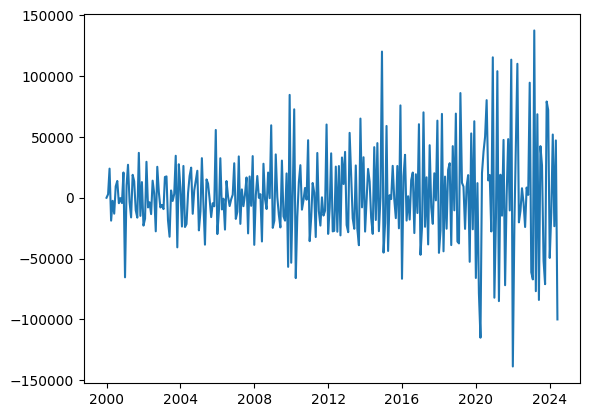

In [197]:
plt.plot(regular_diff)

In [198]:
scaler = StandardScaler()
regular_diff_scaled = scaler.fit_transform(regular_diff)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [199]:
num_separacion = consumo.index[consumo["Fecha"]==pd.to_datetime("2021-12")][0]
num_val = int(len(regular_diff_scaled)*0.1)
train = regular_diff_scaled[:num_separacion-num_val]
validation = regular_diff_scaled[num_separacion-num_val:num_separacion]
test = regular_diff_scaled[num_separacion:]
#train = regular_diff[:num_separacion]
#test = regular_diff[num_separacion:]

In [200]:
def df_a_X_y(df,retrasos = 1):
    if type(df) is pd.DataFrame:
        df_as_np = df.to_numpy()
    else:
        df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-retrasos):
        row = [a for a in df_as_np[i:(i+retrasos)]]
        X.append(row)
        label = df_as_np[i+retrasos][0]
        y.append(label)
        
    return np.array(X), np.array(y)


retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [201]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [202]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [203]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4074 - val_loss: 2.0995
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3885 - val_loss: 2.0651
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3789 - val_loss: 2.0394
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3719 - val_loss: 2.0193
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3664 - val_loss: 2.0037
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3622 - val_loss: 1.9923
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3594 - val_loss: 1.9846
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3577 - val_loss: 1.9787
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3568 - val_loss: 1.9754
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3567 - val_loss: 1.9735
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3567 - val_loss: 1.9720
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3571 - val_loss: 1.9701
Epoch 13/50


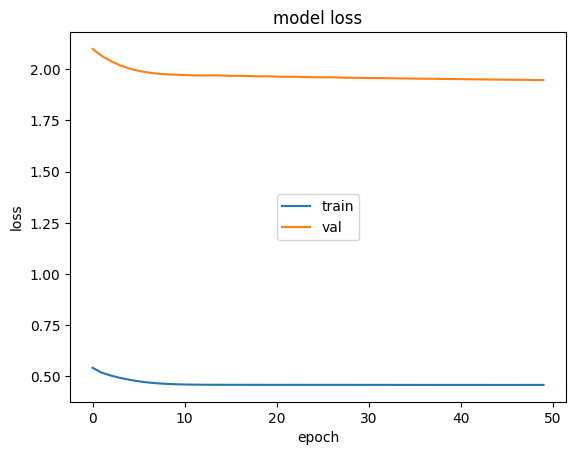

In [204]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [205]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.3601
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9473
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2754


2.275378465652466

In [206]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1, retrasos = 1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        yhat = modelo.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+retrasos-1+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

In [207]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

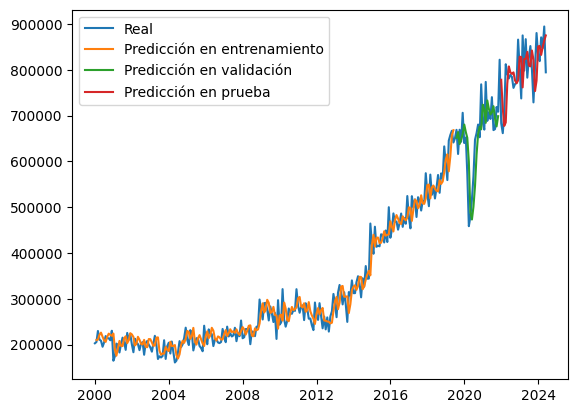

In [208]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[1:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+1:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+1:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

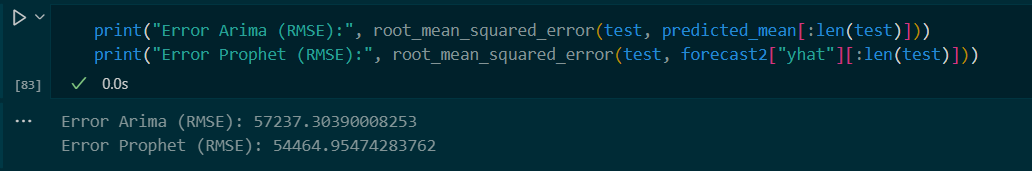

In [209]:
from IPython.display import Image
Image("ErroresRegular.png")

Error del primer LSTM:

In [210]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 58683.07535573883


### Creación segundo modelo

In [211]:
retrasos = 2
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

modelo2 = Sequential()

modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(16, 'relu'))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,081 (70.63 KB)

 Trainable params: 18,081 (70.63 KB)

 Non-trainable params: 0 (0.00 B)

In [212]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [213]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4220 - val_loss: 2.2839
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4032 - val_loss: 2.2806
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3931 - val_loss: 2.2908
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3850 - val_loss: 2.3121
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3785 - val_loss: 2.3449
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3728 - val_loss: 2.3876
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3674 - val_loss: 2.4347
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3624 - val_loss: 2.4867
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3587 - val_loss: 2.5379
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3557 - val_loss: 2.5893
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3530 - val_loss: 2.6393
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3504 - val_loss: 2.6890


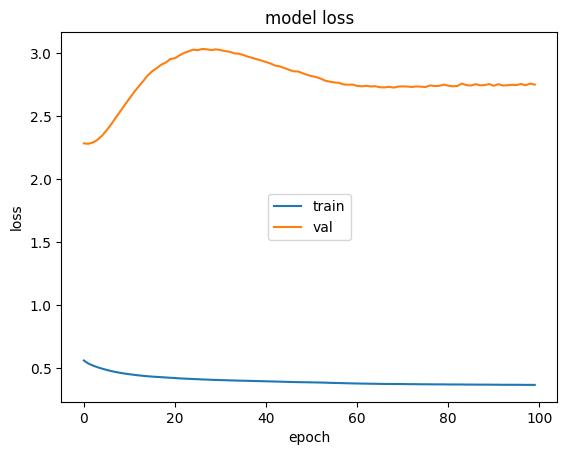

In [214]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [215]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.3113
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7502
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9557


1.9557431936264038

In [216]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

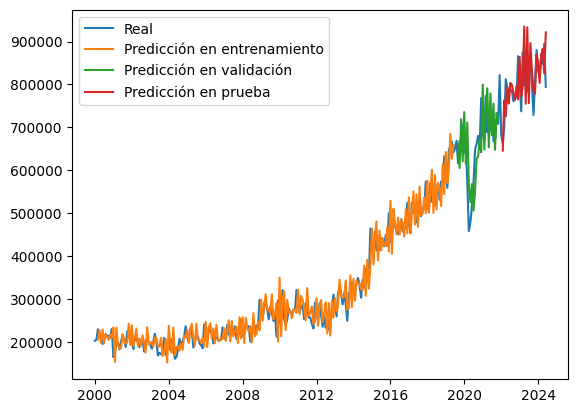

In [217]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+retrasos:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Error del segundo LSTM:

In [218]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 65322.21348737939


## Importación Diesel

In [219]:
diesel = importacion[['Fecha', 'Diesel']].copy()
diesel.set_index('Fecha', inplace = True)


In [220]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
dieselDiFu = adfuller(diesel, autolag = "AIC")
salidaDf = pd.Series(dieselDiFu[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dieselDiFu[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba         -0.813057
p-value                        0.815257
# de retardos usados          13.000000
# de observaciones usadas    268.000000
Critical Value (1%)           -3.454988
Critical Value (5%)           -2.872386
Critical Value (10%)          -2.572549
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [221]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
diesel_diff = diesel.diff()
diesel_diff.fillna(0,inplace = True)
dieselDiFu = adfuller(diesel_diff, autolag = "AIC")
salidaDf = pd.Series(dieselDiFu[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dieselDiFu[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba       -8.990378e+00
p-value                      6.917734e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.690000e+02
Critical Value (1%)         -3.454896e+00
Critical Value (5%)         -2.872345e+00
Critical Value (10%)        -2.572528e+00
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

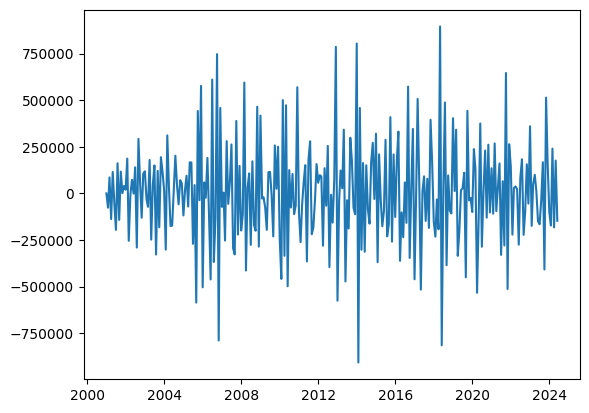

In [222]:
plt.plot(diesel_diff)

In [223]:
scaler = StandardScaler()
diesel_diff_scaled = scaler.fit_transform(diesel_diff)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [224]:
train_size = int(len(diesel) * 0.7)
vals_size = int(len(diesel) * 0.8)
train = diesel_diff_scaled[:train_size]
validation = diesel_diff_scaled[train_size:vals_size]
test = diesel_diff_scaled[vals_size:]

In [225]:
def df_a_X_y(df,retrasos = 1):
    if type(df) is pd.DataFrame:
        df_as_np = df.to_numpy()
    else:
        df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-retrasos):
        row = [a for a in df_as_np[i:(i+retrasos)]]
        X.append(row)
        label = df_as_np[i+retrasos][0]
        y.append(label)
        
    return np.array(X), np.array(y)


retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [226]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [228]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8154 - val_loss: 1.3792
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7810 - val_loss: 1.3499
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7553 - val_loss: 1.3165
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7286 - val_loss: 1.2879
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7066 - val_loss: 1.2637
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6883 - val_loss: 1.2426
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6725 - val_loss: 1.2239
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6592 - val_loss: 1.2072
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6480 - val_loss: 1.1923
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6386 - val_loss: 1.1790
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6308 - val_loss: 1.1670
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6243 - val_loss: 1.1562
Epoch 13/50


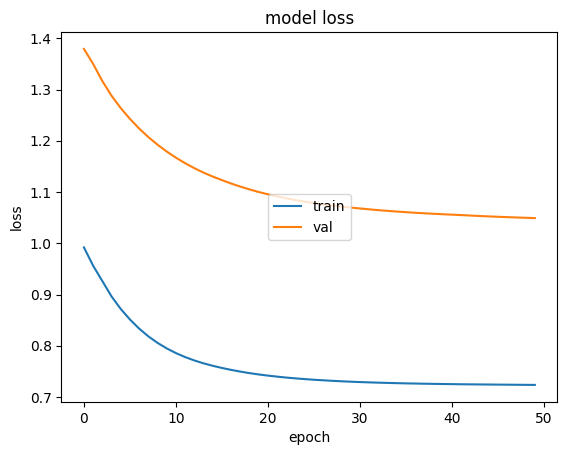

In [229]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [230]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.5879
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0491
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5542 


0.5392267107963562

In [231]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler,dif=True,dif_cant=1, Series = diesel.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=train_size, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=vals_size, retrasos = retrasos)

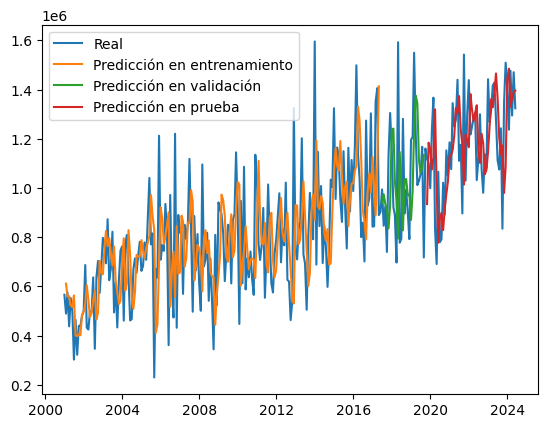

In [232]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = diesel[1:train_size].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = diesel[train_size+1:vals_size].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = diesel[vals_size+1:].index)

plt.plot(diesel, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

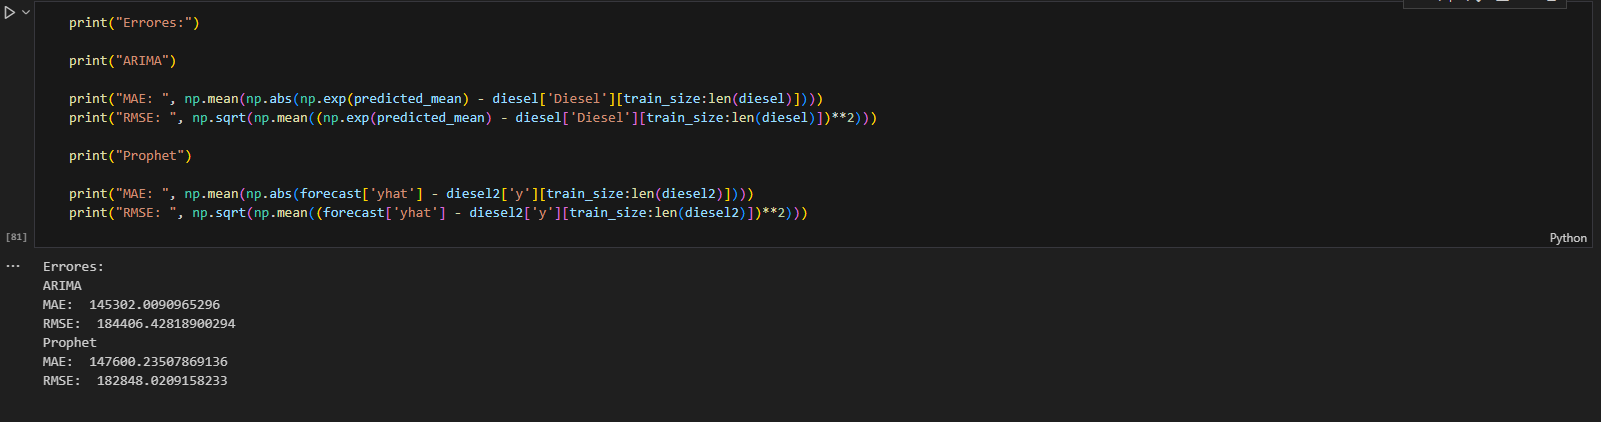

In [233]:
from IPython.display import Image
Image("ErroresDiesel.png")

Error del primer LSTM:

In [234]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(diesel[vals_size+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 200996.62884695397


### Creación segundo modelo

In [235]:

retrasos = 7
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

In [236]:
modelo2 = Sequential()


modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [237]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [238]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8722 - val_loss: 1.6015
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8435 - val_loss: 1.5622
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8248 - val_loss: 1.5253
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8066 - val_loss: 1.4871
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7829 - val_loss: 1.4351
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7561 - val_loss: 1.3857
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7294 - val_loss: 1.3341
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7013 - val_loss: 1.2812
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6721 - val_loss: 1.2273
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6421 - val_loss: 1.1735
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6114 - val_loss: 1.1225
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5813 - val_loss: 1.0747


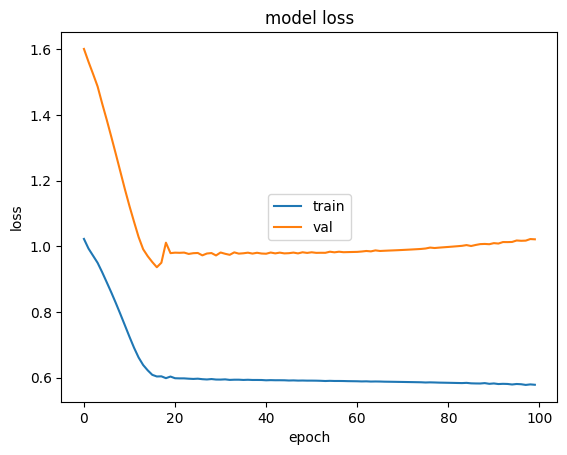

In [239]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [240]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 0.5049
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0214
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5196 


0.5205272436141968

In [241]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler,dif=True,dif_cant=1, Series = diesel.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=train_size, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = diesel.values , n=vals_size, retrasos = retrasos)

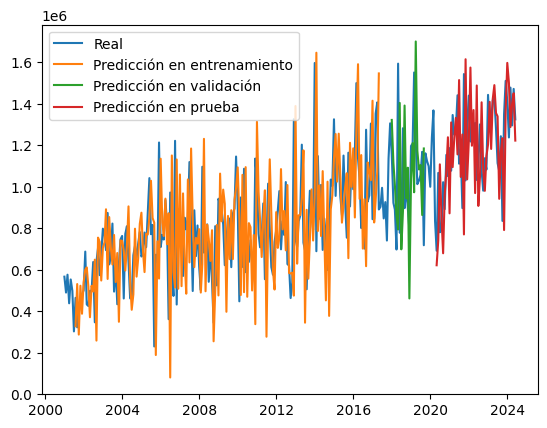

In [242]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = diesel[retrasos:train_size].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = diesel[train_size+retrasos:vals_size].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = diesel[vals_size+retrasos:].index)

plt.plot(diesel, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

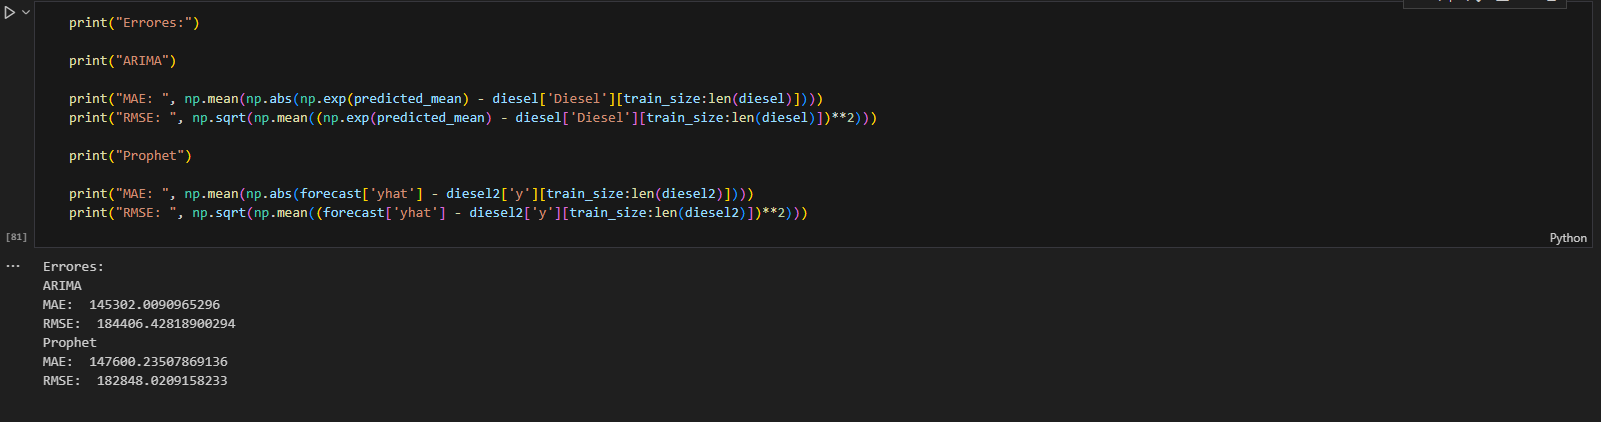

In [243]:
from IPython.display import Image
Image("ErroresDiesel.png")

Error del segundo LSTM:

In [244]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(diesel[vals_size+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 267869.06393233937


### Discusión

El primer modelo sobre la importación de Diesel tenía 1 retraso y contó con 50 épocas de entrenamiento, mientras que el segundo contaba con 7 retrasos y 100 épocas de entrenamiento. Ambos constaban con 64 neuronas LSTm, con una capa de 8 densas y una única densa para realizar la predicción. El primer modelo genero mejores predicciones con un RMSE de 200,137, mientras que el seugndo genero un RMSE de 267,869. Ambos de estos modelos sin embargo fueron peores que los modelos generados en el laboratorio 2, un ARIMA y un Prophet. El que mejor se ajustó fue el modelo Prophet, con un RMSE de 182,848.  

Mientras que el RMSE es alto, se debe considerar que la escala de las importaciones es de más de 1,000,000 en promedio, por lo que el error relativo podría no ser tan grande. Sin embargo por los errores se puede asumir que estos datos no se prestan a ser modelados muy cercanamente, probablemente a lo volatil que es el mercado del petroleo y el gas. 

## Precio de Gasolina Superior

In [245]:
superior = precios[["Fecha", "Superior"]].copy()
superior.set_index("Fecha", inplace = True)
superior.head()


,Superior
Fecha,
2021-01-01,21.91
2021-01-02,21.91
2021-01-03,21.91
2021-01-04,21.91
2021-01-05,21.91


In [246]:
print("Prueba de Dickey-Fuller para la serie de tiempo del precio de gasolina superior")
superiorTest = adfuller(superior, autolag = "AIC")
salidaDf = pd.Series(superiorTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in superiorTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo del precio de gasolina superior
Estadístico de prueba          -2.963637
p-value                         0.038433
# de retardos usados            7.000000
# de observaciones usadas    1318.000000
Critical Value (1%)            -3.435321
Critical Value (5%)            -2.863735
Critical Value (10%)           -2.567939
dtype: float64


El valor-p de la prueba ADF confirma que es una serie de tiempo estacionaria en media. Por lo tanto, no es necesario diferenciarla.

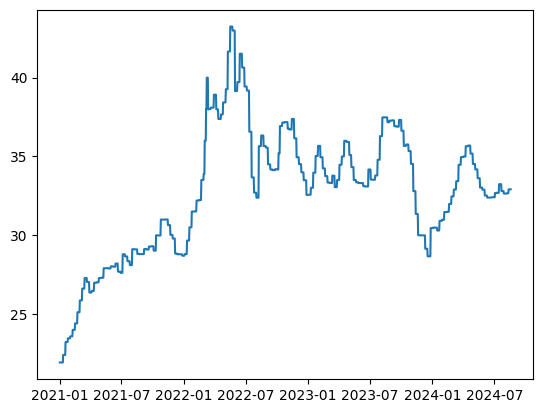

In [247]:
plt.plot(superior)

In [248]:
scaler3 = StandardScaler()
superior_scaled = scaler3.fit_transform(superior)

### Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [249]:
num_separacion = precios.index[precios["Fecha"]==pd.to_datetime("2023-12-31")][0]
num_val = int(len(superior_scaled)*0.1)
train = superior_scaled[:num_separacion-num_val]
validation = superior_scaled[num_separacion-num_val:num_separacion]
test = superior_scaled[num_separacion:]

In [250]:
retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [251]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [252]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [253]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9883 - val_loss: 0.5552
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7358 - val_loss: 0.4214
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4837 - val_loss: 0.2998
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2319 - val_loss: 0.1927
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9817 - val_loss: 0.1078
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7433 - val_loss: 0.0489
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5292 - val_loss: 0.0182
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3569 - val_loss: 0.0092
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2365 - val_loss: 0.0100
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1652 - val_loss: 0.0132
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1268 - val_loss: 0.0143
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1055 - val_lo

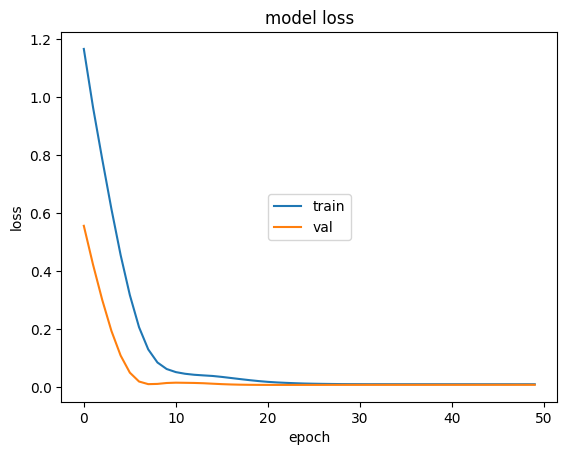

In [254]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [255]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0065
Pérdida en Validación
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0051   
Pérdida en Prueba
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.0017   


0.0018633122090250254

In [256]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler3,dif=False)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler3,dif=False)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler3,dif=False)

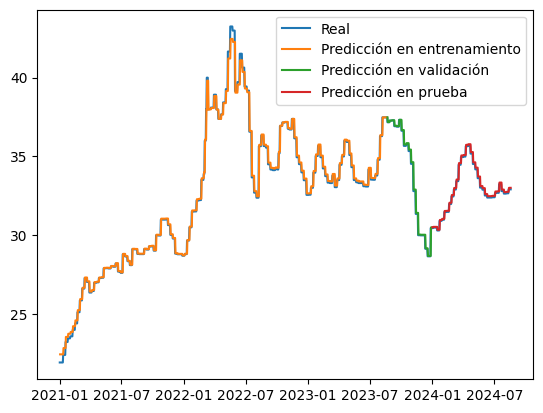

In [257]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = superior[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = superior[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = superior[num_separacion+retrasos:].index)

plt.plot(superior, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

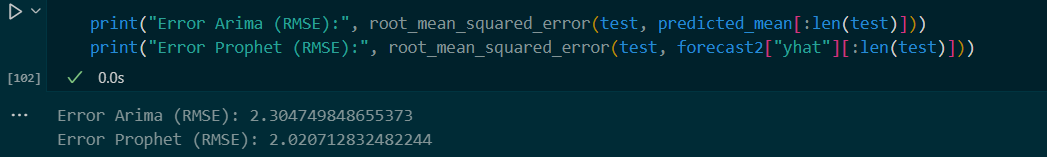

In [258]:
Image("ErroresSuperior.png")

Error del primer LSTM:

In [259]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(superior[num_separacion+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 0.1762391857266981


### Creación segundo modelo

In [260]:
retrasos = 7
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

modelo2 = Sequential()

modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [261]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [262]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8298 - val_loss: 0.1809
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8424 - val_loss: 0.0372
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2838 - val_loss: 0.0218
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1301 - val_loss: 0.0217
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1012 - val_loss: 0.0219
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0799 - val_loss: 0.0219
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0647 - val_loss: 0.0219
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0539 - val_loss: 0.0218
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - val_loss: 0.0216
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0419 - val_loss: 0.0214
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0386 - val_loss: 0.0212
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

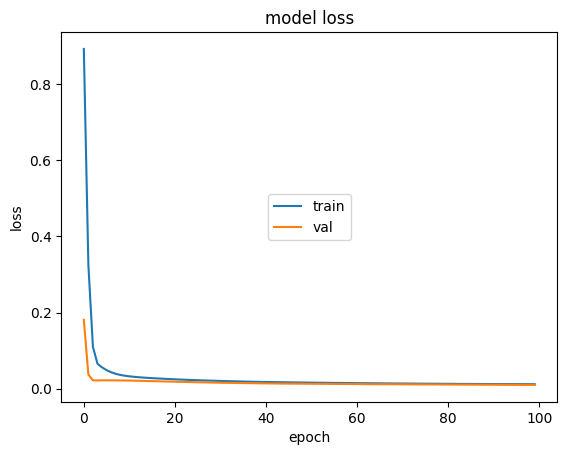

In [263]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [264]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.0076
Pérdida en Validación
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064     
Pérdida en Prueba
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.0027


0.0024023614823818207

In [265]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler3,dif=False)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler3,dif=False)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler3,dif=False)

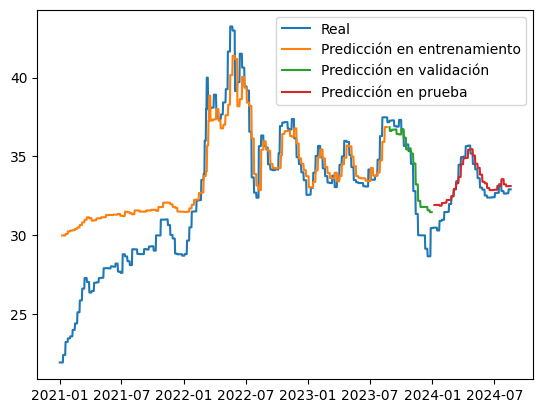

In [266]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = superior[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = superior[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = superior[num_separacion+retrasos:].index)

plt.plot(superior, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Error del segundo LSTM:

In [267]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(superior[num_separacion+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 0.6641690773257185
